In [1]:
import os
import cv2
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import time
from custom_loader import CustomLoader
from torchvision import transforms
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
path_train = '/home/m20163692/data/stl10/imgs/train/'
path_test = '/home/m20163692/data/stl10/imgs/test/'
model_data = 'model_weights'
img_size = 96
upscale_factor = 4
batch_size = 2048
threads = 8
n_gpu = 2
input_size = img_size // upscale_factor
print(f'input img = {input_size}x{input_size}, hres img = {img_size}x{img_size}')

input img = 24x24, hres img = 96x96


In [3]:
%%time
input_transfrom = transforms.Compose([
                      transforms.Scale(input_size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transfrom = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_train = CustomLoader(path_train,
                          transform=input_transfrom,
                          target_transform=target_transfrom)
data_test = CustomLoader(path_test,
                         transform=input_transfrom,
                         target_transform=target_transfrom)
dloader_train = torch.utils.data.DataLoader(data_train, batch_size, True, num_workers=threads)
dloader_test = torch.utils.data.DataLoader(data_test, batch_size, num_workers=threads)

CPU times: user 617 ms, sys: 50.1 ms, total: 667 ms
Wall time: 665 ms


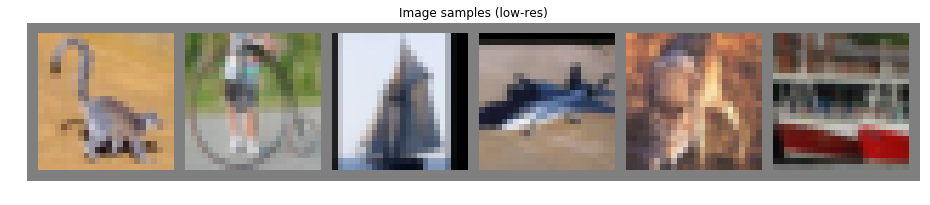

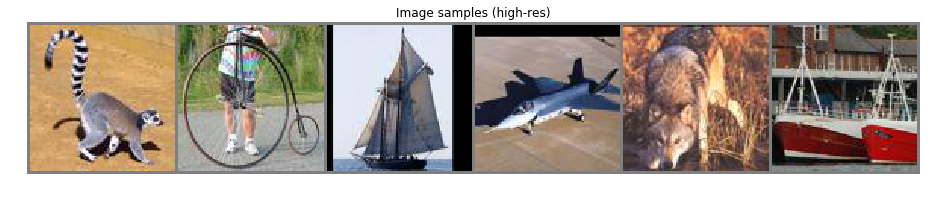

In [4]:
to_np = lambda x: np.transpose((x/2+0.5).clamp(0,1).numpy(), (1,2,0))

def show(img, fs=(4,4), title=None):
    plt.figure(figsize = fs)
    plt.imshow(to_np(img), interpolation='nearest')
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

temp = iter(dloader_train).next()
show(make_grid(temp[0][:6], nrow=6), (16,16), 'Image samples (low-res)')
show(make_grid(temp[1][:6], nrow=6), (16,16), 'Image samples (high-res)')
del(temp)

# Create model

In [5]:
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import model; importlib.reload(model)
from model import SuperRes
from torch import FloatTensor as FT

def Var(*params):
    return Variable(FT(*params).cuda())

net = SuperRes(n_gpu, upscale_factor).cuda()
net_loss = nn.MSELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [6]:
from collections import deque
from math import log10

def train(epochs):
    total = len(dloader_train)
    h = []
    save_flag = 1
    etas = deque(maxlen=5)
    print(f'Training on {len(dloader_train.dataset)} images for {epochs} epochs\n' +
          f'batch size : {batch_size} - batches per epoch : {total}')
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        t0 = time()
        for idx, batch in enumerate(dloader_train, 1):
            # inputs
            input = Variable(batch[0].cuda())
            target = Variable(batch[1].cuda())
            # backprop
            net.zero_grad()
            loss = net_loss(net(input), target)
            epoch_loss += loss.data[0]
            loss.backward()
            optimizer.step()
            
            pline1 = f'Epoch[{epoch+1}]({idx}/{total}): Loss: %.4f' % loss.data[0]
            print(pline1, end='\r')
        
        etas.append(time() - t0)
        h.append(epoch_loss / total)
        pline2 = f'Epoch {epoch+1} Complete: Avg. Loss: %.4f' % (h[-1]) +\
                 ' [elapsed:%.2fs - ETA:%.2fs]' % (etas[-1], (epochs-epoch-1) * np.mean(etas))
                 
        print(pline2 + ' '*max(0, (len(pline2) - len(pline1))))
        test()
        # Making sure we don't end with a corrupted file if the process gets interrupted:
        save = model_data + '.pkl' if save_flag == 1 else model_data + '_temp.pkl'
        checkpoint(save)
        save_flag *= -1
    
    print()
    return h
        
def test():
    net.eval()
    avg_psnr = 0
    eval_loss = 0
    t = len(dloader_test)
    for batch in dloader_test:
        # inputs
        input = Variable(batch[0].cuda())
        target = Variable(batch[1].cuda())
        # loss
        loss = net_loss(net(input), target)
        eval_loss += loss.data[0]
        psnr = 10 * log10(1 / loss.data[0])
        avg_psnr += psnr
    print('\tAvg. PSNR: %.4f dB - Validation loss: %.4f' % (avg_psnr / t, eval_loss / t))
    
def checkpoint(fpath):
    torch.save({'model': net.state_dict(),
                'optimizer': optimizer.state_dict()}, fpath)
    
def load_checkpoint(fpath=model_data + '.pkl'):
    d = torch.load(fpath)
    net.load_state_dict(d['model'])
    optimizer.load_state_dict(d['optimizer'])
    
def update_lr(lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        

Training on 112500 images for 25 epochs
batch size : 2048 - batches per epoch : 55
Epoch 1 Complete: Avg. Loss: 0.1527 [elapsed:78.39s - ETA:1881.41s]                                      
	Avg. PSNR: 11.3367 dB - Validation loss: 0.0735
Epoch 2 Complete: Avg. Loss: 0.0515 [elapsed:78.17s - ETA:1800.51s]                                      
	Avg. PSNR: 13.5960 dB - Validation loss: 0.0437
Epoch 3 Complete: Avg. Loss: 0.0378 [elapsed:74.66s - ETA:1695.65s]                                      
	Avg. PSNR: 14.5010 dB - Validation loss: 0.0355
Epoch 4 Complete: Avg. Loss: 0.0315 [elapsed:75.03s - ETA:1607.82s]                                      
	Avg. PSNR: 15.1103 dB - Validation loss: 0.0308
Epoch 5 Complete: Avg. Loss: 0.0293 [elapsed:78.39s - ETA:1538.57s]                                      
	Avg. PSNR: 15.5831 dB - Validation loss: 0.0276
Epoch 6 Complete: Avg. Loss: 0.0281 [elapsed:74.98s - ETA:1448.69s]                                      
	Avg. PSNR: 15.4600 dB - Validation 

	Avg. PSNR: 16.6021 dB - Validation loss: 0.0219
Epoch 13 Complete: Avg. Loss: 0.0221 [elapsed:75.70s - ETA:148.92s]                                     
	Avg. PSNR: 16.6062 dB - Validation loss: 0.0218
Epoch 14 Complete: Avg. Loss: 0.0221 [elapsed:74.75s - ETA:74.60s]                                    
	Avg. PSNR: 16.6048 dB - Validation loss: 0.0219
Epoch 15 Complete: Avg. Loss: 0.0221 [elapsed:74.66s - ETA:0.00s]                                   
	Avg. PSNR: 16.5982 dB - Validation loss: 0.0219

Training on 112500 images for 15 epochs
batch size : 2048 - batches per epoch : 55
Epoch 1 Complete: Avg. Loss: 0.0220 [elapsed:75.13s - ETA:1051.86s]                                      
	Avg. PSNR: 16.6112 dB - Validation loss: 0.0218
Epoch 2 Complete: Avg. Loss: 0.0220 [elapsed:74.72s - ETA:974.07s]                                     
	Avg. PSNR: 16.6119 dB - Validation loss: 0.0218
Epoch 3 Complete: Avg. Loss: 0.0220 [elapsed:75.75s - ETA:902.43s]                                     

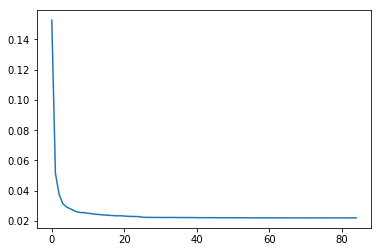

In [7]:
%%time
history = []
history += train(25)
update_lr(1e-3)
history += train(15)
update_lr(5e-4)
history += train(15)
update_lr(1e-4)
history += train(15)
update_lr(1e-5)
history += train(15)
plt.plot(history)

In [8]:
checkpoint(model_data + '.pkl')
os.remove(model_data + '_temp.pkl')

# View

In [7]:
# LOAD
load_checkpoint()

In [15]:
torch.min(temp[0])

TypeError: torch.min received an invalid combination of arguments - got (list), but expected one of:
 * (torch.FloatTensor source)
      didn't match because some of the arguments have invalid types: ([31;1mlist[0m)
 * (torch.FloatTensor source, torch.FloatTensor other)
 * (torch.FloatTensor source, int dim)


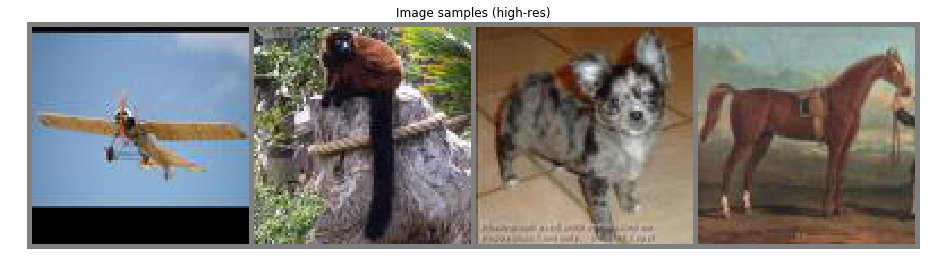

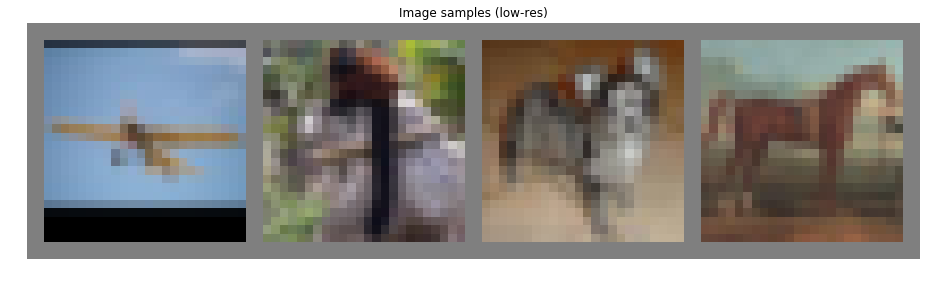

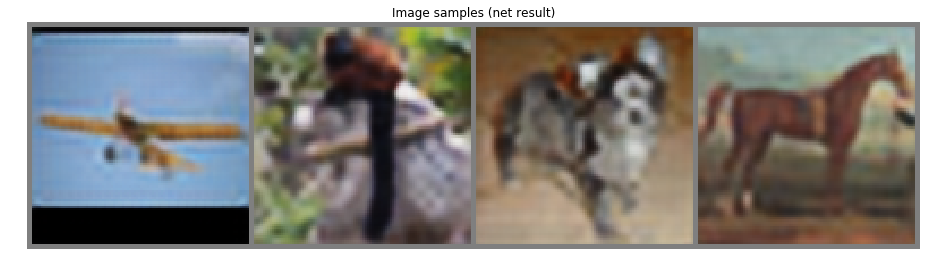

In [10]:
net.eval()
n_imgs = 4
dloader_show = torch.utils.data.DataLoader(data_test, batch_size, True, num_workers=threads)
temp = iter(dloader_show).next()
temp_res = net(Var(temp[0][:n_imgs])).data.cpu()
show(make_grid(temp[1][:n_imgs], nrow=n_imgs), (16,16), 'Image samples (high-res)')
show(make_grid(temp[0][:n_imgs], nrow=n_imgs), (16,16), 'Image samples (low-res)')
show(make_grid(temp_res, nrow=n_imgs), (16,16), 'Image samples (net result)')
# del(temp); del(temp_res)

# Testing on different resolutions

From; 33x25
To  : 132x100


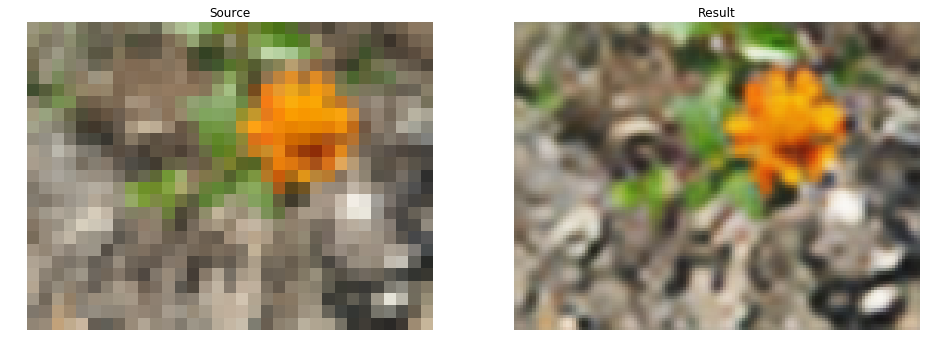

From; 133x100
To  : 532x400


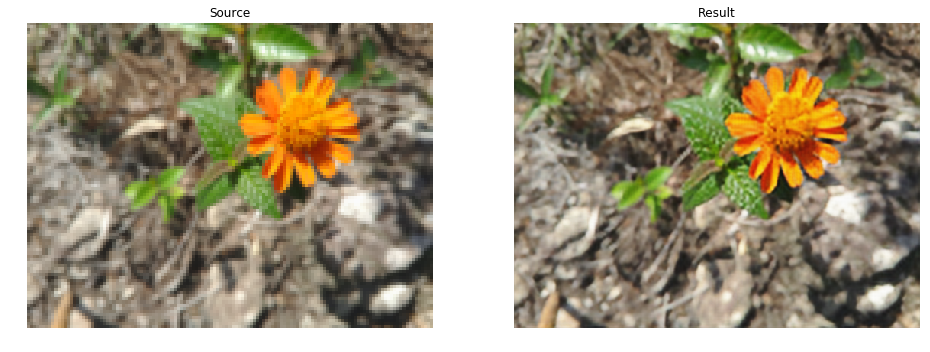

In [11]:
from PIL import Image

transfrom = lambda x: transforms.Compose([
                          transforms.Scale(x),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def upscale_img(path, resize=100, iter=1):
    net.eval()
    test_img = Image.open(path).convert('RGB')
    test_img = transfrom(resize)(test_img)
    test_img.unsqueeze_(0)
    test_res = Var(test_img)
    for _ in range(iter):
        test_res = net(test_res)
    test_res = test_res.data.cpu()
    test_img = to_np(test_img[0])
    test_res = to_np(test_res[0])
    print(f'From; {test_img.shape[1]}x{test_img.shape[0]}')
    print(f'To  : {test_res.shape[1]}x{test_res.shape[0]}')
    
    plt.figure(figsize=(16,16))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img)
    plt.title('Source')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(test_res)
    plt.title('Result')
    plt.axis('off')
    plt.show()

for i in [25, 100]: upscale_img('../P70301-102125.jpg', i)